# Imports

In [1]:
# General
import pandas as pd
import numpy as np
import custom_functions as cf

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
# Set plotting config
cf.set_plot_config()

In [3]:
# Read in data
data = pd.read_csv("music_data.csv")
# Get number of classes
n_classes = data.playlist_genre.nunique()
# Select the target variable
y = data.playlist_genre

# Exploratory Data Analysis

In [ ]:
# Break into audio and lyric features
audio = data[[x for x in data.columns if x.startswith("audio")]]
lyric = data[[x for x in data.columns if x.startswith("lyric")]]
# Make cols neater
audio.columns = audio.columns.str.replace("audio_", "")
lyric.columns = lyric.columns.str.replace("lyric_", "")

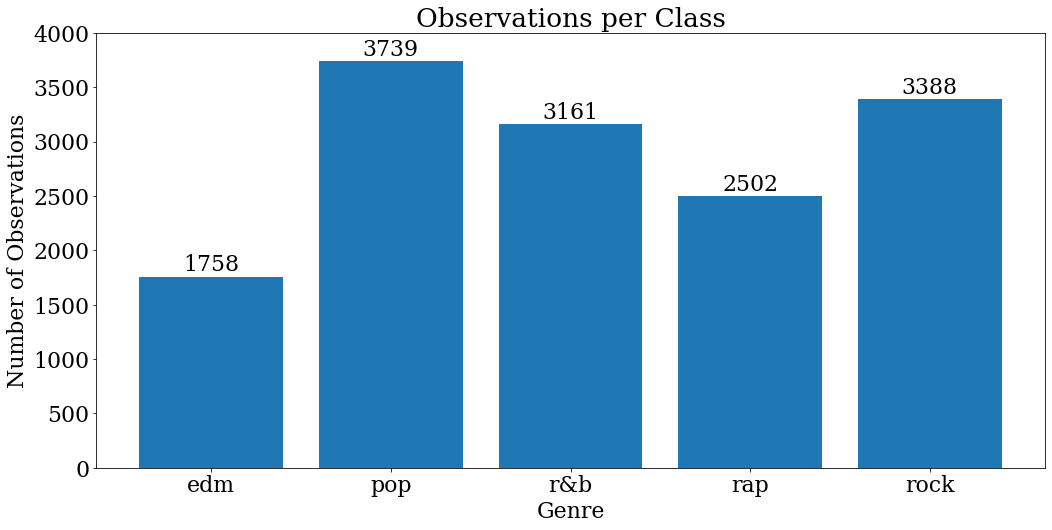

In [ ]:
# Show observations per class
by_genre = data.groupby("playlist_genre")["audio_key"].count().reset_index()
fig, ax = plt.subplots()

ax.bar(by_genre.playlist_genre, by_genre.audio_key)
# Adjust axis and titles
ax.set_ylabel("Number of Observations")
ax.set_xlabel("Genre")
ax.set_title("Observations per Class")
ax.set_ylim(0, 4000)

# Annotate bars
rects = ax.patches
for rect in rects:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, height, ha="center", va="bottom"
    )
# plt.savefig("obs_by_class.png")

In [ ]:
# Check for nulls
data.isnull().values.any()

False

## Audio Feature Analysis

In [ ]:
# Key summary stats of audio features
audio.describe().round(2).drop("count")

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
mean,0.63,0.69,5.31,-6.88,0.59,0.10,0.17,0.05,0.19,0.51,120.95,233592.54
std,0.15,0.18,3.61,2.96,0.49,0.10,0.22,0.15,0.15,0.23,27.36,57756.35
min,0.12,0.02,0.00,-34.28,0.00,0.02,0.00,0.00,0.01,0.03,37.11,31893.00
25%,0.53,0.56,2.00,-8.45,0.00,0.04,0.01,0.00,0.09,0.34,99.96,195873.00
50%,0.64,0.71,5.00,-6.34,1.00,0.06,0.07,0.00,0.13,0.51,120.28,224635.00
75%,0.74,0.84,8.00,-4.77,1.00,0.12,0.23,0.00,0.25,0.68,136.06,262266.75
max,0.98,1.00,11.00,1.27,1.00,0.92,0.99,0.97,1.00,0.99,212.14,517125.00


In [ ]:
# Find categorical variables that may need to be treated differently later
possible_categoricals = audio.select_dtypes(include = ["category", "int"])
# Get unique results for each column
possible_categoricals.T.groupby(possible_categoricals.columns).apply(lambda x: list(np.unique(x)))

duration_ms    [31893, 37640, 57373, 62375, 66786, 67400, 675...
key                       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
mode                                                      [0, 1]
dtype: object

<b>[Seaborn Correlation Heatmap](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

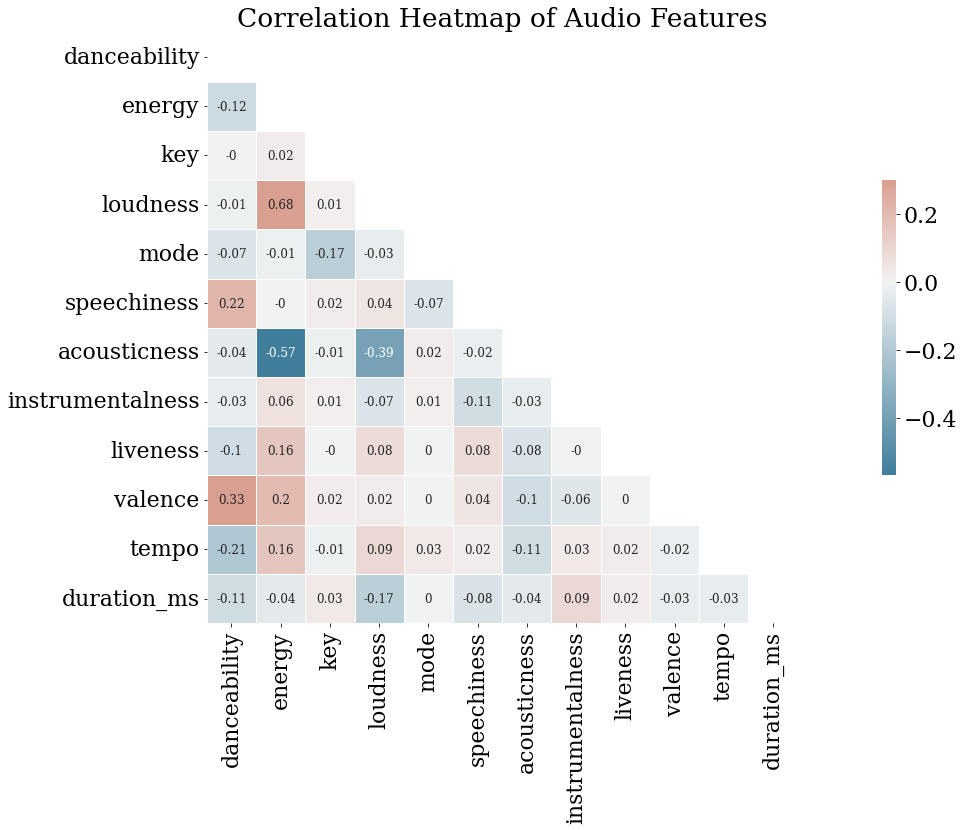

In [ ]:
# Look at correlations of audio data
# Compute the correlation matrix
corr = audio.corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize = (24, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size":12}).set_title("Correlation Heatmap of Audio Features")
plt.tight_layout()
# plt.savefig("audio_corrs.png")

## Sparsity

In [ ]:
# Calculate sparsity across audio and lyric columns
lyric_sparsity = pd.DataFrame({"lyric_cols":lyric.apply(cf.calc_sparsity).agg(["mean", "median", "min", "max"])}).T
audio_sparsity = pd.DataFrame({"audio_cols":audio.apply(cf.calc_sparsity).agg(["mean", "median", "min", "max"])}).T
sparsity = pd.concat([lyric_sparsity, audio_sparsity])
sparsity

,mean,median,min,max
lyric_cols,0.964741,0.984671,0.326093,0.999656
audio_cols,0.073641,0.000000,0.000000,0.408785


## PCA

In [ ]:
# Normalise all features for better modelling + PCA
scaler = MinMaxScaler()
audio_features = scaler.fit_transform(audio)
lyric_features = scaler.fit_transform(lyric)

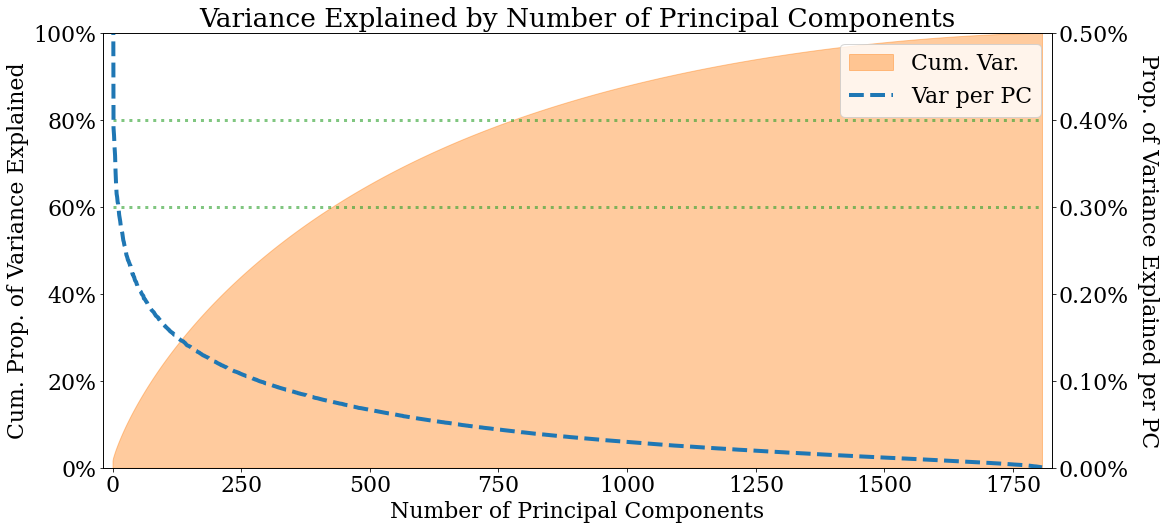

In [ ]:
# Set seed for reproducibility
cf.set_seed()
# Do dimension reduction/PCA on lyric features
pca = PCA()
pca.fit(lyric_features)
# Get principal components for lyric features
# No sparsity observed now
lyric_pca = pca.transform(lyric_features)

# Plot elbow/scree plot to get indication of good number of PCs to keep
cf.plot_scree_pca(var_explained_ratio = pca.explained_variance_ratio_)
# plt.savefig("pca_var.png")

## t-SNE

In [ ]:
# Merge numeric labels with normalised audio data and lyric principal components
tsne_processed = pd.concat([
    pd.Series(y, name = "genre"),
    pd.DataFrame(audio_features, columns=audio.columns),
    # Add prefix to make selecting pcs easier later on
    pd.DataFrame(lyric_pca).add_prefix("lyrics_pc_")
          ], axis = 1)
tsne_processed.head(1)

,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,lyrics_pc_1797,lyrics_pc_1798,lyrics_pc_1799,lyrics_pc_1800,lyrics_pc_1801,lyrics_pc_1802,lyrics_pc_1803,lyrics_pc_1804,lyrics_pc_1805,lyrics_pc_1806
0,rock,0.216686,0.878856,0.818182,0.830868,1.0,0.024341,0.011793,0.010258,0.342212,...,0.002733,-0.000142,-0.000306,-0.000464,-0.000646,0.001292,7.427609e-08,0.000178,0.001572,0.000411


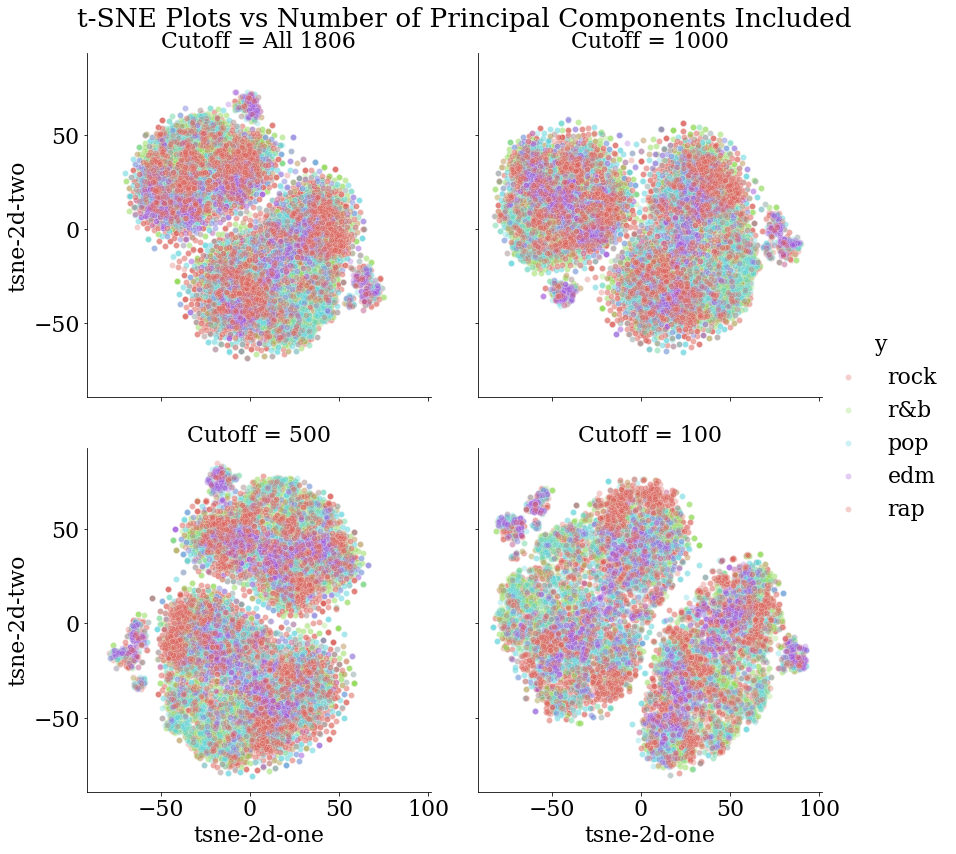

In [ ]:
# Set seed for reproducibility
cf.set_seed()
# Get t-SNE values for a range of principal component cutoffs, 1806 is all PCs
all_tsne = pd.DataFrame()
for cutoff in ["1806", "1000", "500", "100"]:
    # Create t-SNE object
    tsne = TSNE(init = "random", learning_rate = "auto")
    # Fit on relevant, normalised features
    tsne_results = tsne.fit_transform(tsne_processed.loc[:, "danceability":f"lyrics_pc_{cutoff}"])
    
    # neater graph
    if cutoff == "1806":
        cutoff = "All 1806"
    # Get results
    tsne_df = pd.DataFrame({"y":y,
                        "tsne-2d-one":tsne_results[:,0],
                       "tsne-2d-two":tsne_results[:,1],
                           "Cutoff":cutoff})
    # Store results
    all_tsne = pd.concat([all_tsne, tsne_df], axis = 0)
    
# Plot t-SNEs
cf.plot_tsne(all_tsne)
# plt.savefig("tsne.png")